In [71]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'




In [72]:
ls /mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/*so3*

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220511_so3_exp_0:
C_bd0/  C_bd0id1/  C_bd0id2/  config.yml  log

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220611_so3:
config.yml                    snapshot_model_iter_20000
log                           snapshot_model_iter_25000
snapshot_manager_iter_100000  snapshot_model_iter_30000
snapshot_model_iter_10000     snapshot_model_iter_40000
snapshot_model_iter_100000    snapshot_model_iter_50000
snapshot_model_iter_125000    snapshot_model_iter_75000

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220611_so3_so3run:
config.yml                    snapshot_model_iter_175000
log                           snapshot_model_iter_200000
snapshot_manager_iter_200000  snapshot_model_iter_25000
snapshot_model_iter_100000    snapshot_model_iter_50000
snapshot_model_iter_125000    snapshot_model_iter_75000
snapshot_model_iter_150000

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220611_so3_so3run_rcst:
config.yml   

In [70]:
targdir = '20220701_so3_various_dat_three_0'
exp_result = os.path.join(result_dir, targdir)


def iter_list(log_dir):
    dirlist = os.listdir(log_dir)
    iterlist = []
    for mydir in dirlist:
        if 'iter' in mydir:
            iterlist.append(int(mydir.split('_')[-1]))
    return np.array(iterlist)
    
    
def load_model(model, log_dir, iters, latest=False):
    print('snapshot_model_iter_{}'.format(iters))
    if latest == True:
        iters = np.max(iter_list(log_dir))
    model.load_state_dict(torch.load(os.path.join(log_dir, 'snapshot_model_iter_{}'.format(iters))))



def load_config(targdir_path):
    targ_config_path = os.path.join(targdir_path, 'config.yml')
    with open(targ_config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config
    
    
def filter_names(query, mydict):
    filtered = {} 
    for key in mydict.keys():
        if query in key:
            filtered[key] = mydict[key]
    return filtered
    
    
os.listdir(exp_result)



['data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_so3Net',
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_so3Net',
 'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_so3Net']

In [4]:
results = {} 
tp = 3
n_cond = 5

for targdir in os.listdir(exp_result):
    
    targdir_path = os.path.join(exp_result, targdir)
    config = load_config(targdir_path)
    
    dataconfig = config['train_data']
    dataconfig['args']['T'] = tp + n_cond
    
    data = yu.load_component(dataconfig)
    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])
    model = yu.load_component(config['model'])
    iterlist = iter_list(targdir_path)
    
    if len(iterlist) == 0:
        print(f"""There is no model trained for {targdir_path}""")
    else:
        maxiter = np.max(iter_list(targdir_path))
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)

        # Initialize lazy modules
        images = iter(train_loader).next()
        images = images.to(device)
        model(images[:, :2])

        with torch.no_grad():
            scores = [] 
            for images in tqdm(train_loader):
                images = images.to(device)
                images_cond = images[:, :n_cond]
                images_target = images[:, n_cond:n_cond+tp]
                M = model.get_M(images_cond) #n a a
                H = model.encode(images_cond[:, -1:])[:, 0] # n s a

                xs = []
                for r in range(tp):
                    H = H @ M 
                    x_next_t = model.decode(H[:, None])
                    xs.append(x_next_t)

                x_next = torch.cat(xs, axis=1)
                r2_losses = [] 
                for k in range(tp):
                    r2_loss_t = r2_score(images_target[:,k].to('cpu').numpy(), x_next[:,k].to('cpu').numpy()) 
                    r2_losses.append(r2_loss_t)
                scores.append(torch.tensor(r2_losses))

                
                
        scores = torch.stack(scores)
        av_score = torch.mean(scores, axis=0)
        av_var = torch.var(scores, axis=0)
        results[targdir] = [av_score, av_var]
    
            
            
                
            

            


    
    
    

/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


snapshot_model_iter_1000000


100%|██████████| 313/313 [00:01<00:00, 187.65it/s]


snapshot_model_iter_1000000


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:01<00:00, 206.04it/s]


snapshot_model_iter_1000000


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:01<00:00, 179.10it/s]


snapshot_model_iter_1000000


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:01<00:00, 174.23it/s]


snapshot_model_iter_1000000


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:01<00:00, 180.54it/s]


snapshot_model_iter_1000000


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:01<00:00, 197.95it/s]


In [5]:
results
    

{'data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_LinearNet': [tensor([0.4972, 0.2769, 0.0926], dtype=torch.float64),
  tensor([0.0015, 0.0025, 0.0039], dtype=torch.float64)],
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_LinearNet': [tensor([0.9999, 0.9999, 0.9999], dtype=torch.float64),
  tensor([1.0128e-10, 1.1476e-10, 1.1639e-10], dtype=torch.float64)],
 'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_so3Net': [tensor([0.8722, 0.8332, 0.8078], dtype=torch.float64),
  tensor([8.8108e-05, 2.0614e-04, 2.4788e-04], dtype=torch.float64)],
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_so3Net': [tensor([0.8760, 0.7877, 0.7320], dtype=torch.float64),
  tensor([0.0002, 0.0005, 0.0009], dtype=torch.float64)],
 'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_LinearNet': [tensor([0.9975, 0.9956, 0.9947], dtype=torch.float64),
  tensor([6.2536e-08, 1.0598e-07, 1.4318e-07], dtype=torch.float64)],
 'data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_so3Net': [tensor([-0.0717,

In [6]:
filter_names('dat_sphere_iResNetpt', results)

{'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_so3Net': [tensor([0.8722, 0.8332, 0.8078], dtype=torch.float64),
  tensor([8.8108e-05, 2.0614e-04, 2.4788e-04], dtype=torch.float64)],
 'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_LinearNet': [tensor([0.9975, 0.9956, 0.9947], dtype=torch.float64),
  tensor([6.2536e-08, 1.0598e-07, 1.4318e-07], dtype=torch.float64)]}

In [7]:
filter_names('dat_sphere_Linearpt', results)

{'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_LinearNet': [tensor([0.9999, 0.9999, 0.9999], dtype=torch.float64),
  tensor([1.0128e-10, 1.1476e-10, 1.1639e-10], dtype=torch.float64)],
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_so3Net': [tensor([0.8760, 0.7877, 0.7320], dtype=torch.float64),
  tensor([0.0002, 0.0005, 0.0009], dtype=torch.float64)]}

In [8]:
filter_names('dat_sphere_MLPpt', results)

{'data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_LinearNet': [tensor([0.4972, 0.2769, 0.0926], dtype=torch.float64),
  tensor([0.0015, 0.0025, 0.0039], dtype=torch.float64)],
 'data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_so3Net': [tensor([-0.0717, -0.0724, -0.0734], dtype=torch.float64),
  tensor([0.0005, 0.0006, 0.0007], dtype=torch.float64)]}

# TODO:  

## (1) Check Equiv  (DONE)
 
## (2) Recreate the dataset and run again  (DONE)

# Equivariance Error 

In [9]:
datamode = 'MLP'

dataconfig_shared = {'args': {'T': 8, 'data_filename': f"""so3dat_sphere_{datamode}_shared_trans.pt""", 'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}

data_shared = yu.load_component(dataconfig_shared)


    


In [10]:
# Initialize lazy modules
results_equiv = {} 
tp = 3
n_cond = 5

for targdir in os.listdir(exp_result):
    
    targdir_path = os.path.join(exp_result, targdir)
    config = load_config(targdir_path)
    
    
    '''
    Modify the dataset
    '''
    
    dataconfig = config['train_data']
    original_datfile = dataconfig['args']['data_filename']
    trans_datfile = original_datfile.split('.')[0] + '_shared_trans.pt'  
    dataconfig['args']['data_filename'] = trans_datfile   
    dataconfig['args']['T'] = tp + n_cond
    
    data = yu.load_component(dataconfig)
    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])
    model = yu.load_component(config['model'])
    iterlist = iter_list(targdir_path)
    
    if len(iterlist) == 0:
        print(f"""There is no model trained for {targdir_path}""")
    else:
        maxiter = np.max(iter_list(targdir_path))
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)

        # Initialize lazy modules
        images = iter(train_loader).next()
        images = images.to(device)
        model(images[:, :2])

        with torch.no_grad():
            scores = [] 
            scores_perm = []
            for images in tqdm(train_loader):
                images = images.to(device)
                images_cond = images[:, :n_cond]
                images_target = images[:, n_cond:n_cond+tp]                
                M = model.get_M(images_cond) #n a a
                H = model.encode(images_cond[:, -1:])[:, 0] # n s a
                H_perm = copy.copy(H)

                xs = []
                for r in range(tp):
                    H = H @ M 
                    x_next_t = model.decode(H[:, None])
                    xs.append(x_next_t)
                x_next = torch.cat(xs, axis=1)
                
                swapM = M[torch.arange(-config['batchsize']//2, M.shape[0]-config['batchsize']//2)]
                xs_perm = []
                for r in range(tp):
                    H_perm = H_perm @ swapM 
                    x_next_t_perm = model.decode(H_perm[:, None])
                    xs_perm.append(x_next_t_perm)
                x_next_perm = torch.cat(xs_perm, axis=1)

                r2_losses = [] 
                r2_losses_perm = [] 
                for k in range(tp):
                    r2_loss_t= r2_score(images_target[:,k].to('cpu').numpy(), x_next[:,k].to('cpu').numpy())
                    r2_loss_t_perm = r2_score(images_target[:,k].to('cpu').numpy(), x_next_perm[:,k].to('cpu').numpy()) 

                    r2_losses.append(r2_loss_t)
                    r2_losses_perm.append(r2_loss_t_perm)
                    
                scores.append(torch.tensor(r2_losses))
                scores_perm.append(torch.tensor(r2_losses_perm))

                
                
        scores = torch.stack(scores)
        scores_perm = torch.stack(scores_perm)


        av_score = torch.mean(scores, axis=0)
        av_var = torch.var(scores, axis=0)
        
        av_score_perm = torch.mean(scores_perm, axis=0)
        av_var_perm = torch.var(scores_perm, axis=0)        
        results_equiv[targdir] = {'stat': [av_score, av_var], 'equiv_stat' : [av_score_perm, av_var_perm] } 

snapshot_model_iter_1000000


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:02<00:00, 148.62it/s]


snapshot_model_iter_1000000


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:02<00:00, 147.65it/s]
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


snapshot_model_iter_1000000


100%|██████████| 313/313 [00:02<00:00, 131.36it/s]


snapshot_model_iter_1000000


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:02<00:00, 125.94it/s]


snapshot_model_iter_1000000


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:02<00:00, 143.83it/s]
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


snapshot_model_iter_1000000


100%|██████████| 313/313 [00:02<00:00, 119.58it/s]


In [21]:

filter_names('dat_sphere_iResNetpt', results_equiv)

{'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_so3Net': {'stat': [tensor([0.7679, 0.6418, 0.6643], dtype=torch.float64),
   tensor([0.0002, 0.0005, 0.0005], dtype=torch.float64)],
  'equiv_stat': [tensor([0.5659, 0.3593, 0.4002], dtype=torch.float64),
   tensor([0.0023, 0.0044, 0.0041], dtype=torch.float64)]},
 'data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_LinearNet': {'stat': [tensor([0.9960, 0.9957, 0.9956], dtype=torch.float64),
   tensor([4.4629e-08, 6.1693e-08, 6.2387e-08], dtype=torch.float64)],
  'equiv_stat': [tensor([0.9957, 0.9948, 0.9946], dtype=torch.float64),
   tensor([5.7698e-08, 9.4232e-08, 9.6030e-08], dtype=torch.float64)]}}

In [56]:
filter_names('dat_sphere_MLPpt', results_equiv)

{'data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_LinearNet': {'stat': [tensor([ 0.2746,  0.0455, -0.2162], dtype=torch.float64),
   tensor([0.0012, 0.0018, 0.0025], dtype=torch.float64)],
  'equiv_stat': [tensor([ 0.1960, -0.1668, -0.3550], dtype=torch.float64),
   tensor([0.0014, 0.0028, 0.0034], dtype=torch.float64)]},
 'data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_so3Net': {'stat': [tensor([-0.0733, -0.0751, -0.0748], dtype=torch.float64),
   tensor([0.0005, 0.0007, 0.0007], dtype=torch.float64)],
  'equiv_stat': [tensor([-0.0733, -0.0751, -0.0748], dtype=torch.float64),
   tensor([0.0005, 0.0007, 0.0007], dtype=torch.float64)]}}

In [57]:
filter_names('dat_sphere_Linearpt', results_equiv)

{'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_LinearNet': {'stat': [tensor([0.9999, 0.9999, 0.9999], dtype=torch.float64),
   tensor([8.3245e-11, 6.3317e-11, 6.5848e-11], dtype=torch.float64)],
  'equiv_stat': [tensor([0.9999, 0.9999, 0.9999], dtype=torch.float64),
   tensor([1.0650e-10, 7.8493e-11, 8.0483e-11], dtype=torch.float64)]},
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_so3Net': {'stat': [tensor([0.6749, 0.5347, 0.5402], dtype=torch.float64),
   tensor([0.0013, 0.0010, 0.0011], dtype=torch.float64)],
  'equiv_stat': [tensor([ 0.0799, -0.3896, -0.3093], dtype=torch.float64),
   tensor([0.0153, 0.0302, 0.0259], dtype=torch.float64)]}}

# Problems: 
> iResNet is analyzed with "LINEAR?""

> Are the obtained matrices simultaneously block diag ble? 



In [58]:
from models.base_networks import MLP_iResNet, LinearNet, MLP





In [59]:
ls /mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/so3

so3dat_sphere_Identity.pt             so3dat_sphere_MLP_model.pt
so3dat_sphere_Identity_model.pt       so3dat_sphere_MLP_shared_trans.pt
so3dat_sphere_Linear.pt               so3dat_sphere_iResNet.pt
so3dat_sphere_Linear_model.pt         so3dat_sphere_iResNet_model.pt
so3dat_sphere_Linear_shared_trans.pt  so3dat_sphere_iResNet_shared_trans.pt
so3dat_sphere_MLP.pt


In [60]:
# targdir_path = os.path.join(exp_result, targdir)
# config = load_config(targdir_path)


embed_fxn_mode = 'iResNet'
#embed_fxn_mode = 'Linear'
num_blocks = 2 
tensor_dim = 10 

if embed_fxn_mode == 'iResNet':
    embed_fxn = MLP_iResNet(in_dim=3*num_blocks*tensor_dim)

elif embed_fxn_mode == 'Linear':
    indim= 3 * num_blocks*tensor_dim
    outdim = 3 * num_blocks*tensor_dim
    embed_fxn = LinearNet(in_dim=indim, out_dim=outdim)

elif embed_fxn_mode == 'MLP':
    indim= 3 * num_blocks*tensor_dim
    outdim = 3* num_blocks*tensor_dim
    embed_fxn = MLP(in_dim=indim,
                    out_dim=outdim)
else:
    raise NotImplementedError


embedding_filename = f"""so3dat_sphere_{embed_fxn_mode}_model.pt"""
dat_filename = f"""so3dat_sphere_{embed_fxn_mode}.pt"""
embedding_filepath = os.path.join(rootpath, 'datasets/so3', embedding_filename)


mydict = torch.load(embedding_filepath)
embed_fxn.load_state_dict(mydict)





<All keys matched successfully>

In [61]:
embed_fxn

MLP_iResNet(
  (network): Sequential(
    (0): Invertible_Resblock_Fc(
      (bottleneck_block): Sequential(
        (0): Linear(in_features=60, out_features=60, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=60, out_features=60, bias=True)
      )
    )
    (1): Invertible_Resblock_Fc(
      (bottleneck_block): Sequential(
        (0): Linear(in_features=60, out_features=60, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=60, out_features=60, bias=True)
      )
    )
    (2): Invertible_Resblock_Fc(
      (bottleneck_block): Sequential(
        (0): Linear(in_features=60, out_features=60, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=60, out_features=60, bias=True)
      )
    )
  )
)

In [62]:
# myx = np.linspace(-10, 10, 100)
# myy = np.array(torch.nn.ELU()(torch.tensor(myx) ))
# plt.plot(myx, myy)

In [63]:
data_trial = {'args': {'T': 8,
  'data_filename': dat_filename,
  'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}


data_trial_obj = yu.load_component(data_trial)

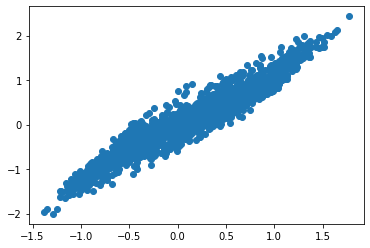

In [64]:
checkdat = data_trial_obj.data[:100]
checkdat = rearrange(checkdat, 'n t a -> (n t) a')
check_latent = embed_fxn(checkdat).detach()

hoge = 12
check_id = hoge
dat_id = hoge
check_slice = check_latent[:, check_id]
dat_slice = checkdat[:, dat_id]

plt.scatter(dat_slice.numpy(), check_slice.numpy())

In [65]:
embed_fxn.__dict__

#param = embed_fxn._modules['network'][0]._modules['bottleneck_block'][2]._parameters['weight_orig']
#plt.imshow(param.detach())

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('network',
               Sequential(
                 (0): Invertible_Resblock_Fc(
                   (bottleneck_block): Sequential(
                     (0): Linear(in_features=60, out_features=60, bias=True)
                     (1): ELU(alpha=1.0)
                     (2): Linear(in_features=60, out_features=60, bias=True)
                   )
                 )
                 (1): Invertible_Resblock_Fc(
                   (bottleneck_block): Sequential(
                     (0): Linear(in_features=60, out_features=60, bias=True)
                     (1): ELU(alpha=1.0)
                     (2): Linear(in_features=60,

In [66]:
embed_fxn._modules

OrderedDict([('network',
              Sequential(
                (0): Invertible_Resblock_Fc(
                  (bottleneck_block): Sequential(
                    (0): Linear(in_features=60, out_features=60, bias=True)
                    (1): ELU(alpha=1.0)
                    (2): Linear(in_features=60, out_features=60, bias=True)
                  )
                )
                (1): Invertible_Resblock_Fc(
                  (bottleneck_block): Sequential(
                    (0): Linear(in_features=60, out_features=60, bias=True)
                    (1): ELU(alpha=1.0)
                    (2): Linear(in_features=60, out_features=60, bias=True)
                  )
                )
                (2): Invertible_Resblock_Fc(
                  (bottleneck_block): Sequential(
                    (0): Linear(in_features=60, out_features=60, bias=True)
                    (1): ELU(alpha=1.0)
                    (2): Linear(in_features=60, out_features=60, bias=True)
            

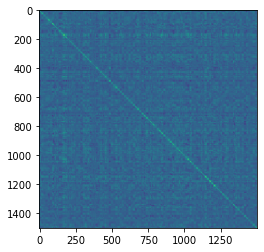

In [67]:
plt.imshow(checkdat @ torch.permute(check_latent , [1,0]))